# Group Assignment       
 
Analysis of the known SMILES       Using mordred descriptors instead of rd kit


In [37]:
# Import packages 
import pandas as pd
from pandas.core.apply import frame_apply
import seaborn as sns
import numpy as np
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
#from rdkit.Chem import Draw
#from rdkit.Chem.Draw import IPythonConsole
from mordred import Calculator, descriptors


import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

## Preprocessing

In [38]:
# Read file
original_df = pd.read_csv('tested_molecules_1.csv')

# Split the column
original_df[['SMILES', 'ALDH1_inhibition']] = original_df['SMILES,"ALDH1_inhibition"'].str.split(',', expand=True)
original_df.drop('SMILES,"ALDH1_inhibition"', axis=1, inplace=True)

original_df['ALDH1_inhibition'] = original_df['ALDH1_inhibition'].str.strip('"')

dataset_new = original_df.copy()

all_descriptors = [desc[0] for desc in Descriptors.descList]

descriptor_data = []
for i, row in original_df.iterrows():
    mol = Chem.MolFromSmiles(row['SMILES'])
    descriptor_values = [getattr(Descriptors, descriptor)(mol) for descriptor in all_descriptors]
    descriptor_data.append(descriptor_values)

descriptor_df = pd.DataFrame(descriptor_data, columns=all_descriptors)
original_df = pd.concat([original_df, descriptor_df], axis=1)

df = original_df.copy()



In [39]:
df

,SMILES,ALDH1_inhibition,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,COc1ccccc1CC(NC(C)=O)C(=O)NC1CCN(c2nnnn2-c2ccc...,1,13.083531,13.083531,0.001173,-0.683140,0.520365,463.542,434.310,463.233188,...,0,0,0,0,1,0,0,0,0,0
1,O=C(CSc1nc2cccnc2n1Cc1ccccc1)NCc1ccco1,1,12.170097,12.170097,0.066966,-0.066966,0.498564,378.457,360.313,378.115047,...,1,0,0,0,0,0,0,0,0,0
2,Cc1cccc2cc(C[NH+](CC3CCCO3)C(c3nnnn3Cc3ccco3)C...,1,10.905837,10.905837,0.016881,-0.016881,0.382043,477.589,444.325,477.260865,...,0,0,0,0,1,0,0,0,0,0
3,CCN(CC)c1ccc2c(Cl)c(Br)c(=O)oc2c1,1,11.562446,11.562446,0.270607,-0.454447,0.795948,330.609,317.505,328.981818,...,0,0,0,0,0,0,0,0,0,0
4,CS(=O)(=O)N1CCc2cc(-c3csc(NC(=O)Cc4cccs4)n3)ccc21,1,12.108866,12.108866,0.086947,-3.251317,0.687618,419.553,402.417,419.043204,...,0,1,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,COc1ccc(N2C(=O)CC([NH2+]C3CC3)C2=O)cc1,0,12.276695,12.276695,0.095308,-0.234165,0.779148,261.301,244.165,261.123369,...,0,0,0,0,0,0,0,0,0,0
996,CCNc1oc(COc2cccc(C)c2)nc1C#N,0,8.926724,8.926724,0.197944,0.197944,0.891297,257.293,242.173,257.116427,...,0,0,0,0,0,0,0,0,0,0
997,NC(=O)Cn1cnc(-c2ccccc2)c1,0,10.688087,10.688087,0.166502,-0.368508,0.805927,201.229,190.141,201.090212,...,0,0,0,0,0,0,0,0,0,0
998,Cc1cc(NC(=O)CSc2nc3c(c(=O)n(C)c(=O)n3C)n2C(C)C...,0,12.603109,12.603109,0.065686,-0.447592,0.644831,392.441,372.281,392.126674,...,1,0,0,0,0,0,0,0,0,0


In [40]:
def morgan_fpts(data):
    Morgan_fpts = []
    for i in data:
        mol = Chem.MolFromSmiles(i) 
        fpts =  AllChem.GetMorganFingerprintAsBitVect(mol,2,2048)
        mfpts = np.array(fpts)
        Morgan_fpts.append(mfpts)  
    return np.array(Morgan_fpts)

In [41]:
Morgan_fpts = morgan_fpts(dataset_new['SMILES'])
Morgan_fpts.shape

(1000, 2048)

In [42]:
Morgan_fingerprints = pd.DataFrame(Morgan_fpts,columns=['Col_{}'.format(i) for i in range(Morgan_fpts.shape[1])])
 # Morgan_fingerprints

In [43]:
def All_Mordred_descriptors(data):
    calc = Calculator(descriptors, ignore_3D=False)
    mols = [Chem.MolFromSmiles(smi) for smi in data]
    
    # pandas df
    df = calc.pandas(mols)
    return df

mordred_descriptors = All_Mordred_descriptors(dataset_new['SMILES'])

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:33<00:00, 10.71it/s]


In [44]:
mordred_descriptors.shape

(1000, 1826)

In [45]:
mordred_descriptors

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,2,0,44.267946,2.421778,4.782141,44.267946,1.301998,4.447008,...,10.305112,83.629003,463.233188,7.352908,3897,51,174.0,202.0,10.111111,7.638889
1,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,0,36.182884,2.465478,4.762845,36.182884,1.340107,4.231676,...,10.027076,77.635894,378.115047,8.402557,2041,36,140.0,162.0,6.527778,6.000000
2,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,2,1,45.572905,2.459519,4.899257,45.572905,1.302083,4.497313,...,10.462503,88.046655,477.260865,7.018542,3583,53,188.0,223.0,10.083333,7.611111
3,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,0,22.630515,2.450890,4.901779,22.630515,1.257251,3.809762,...,9.892882,51.279646,328.981818,10.612317,588,31,92.0,110.0,7.277778,4.138889
4,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,0,34.416867,2.485698,4.851516,34.416867,1.274699,4.245466,...,10.224882,79.186938,419.043204,9.523709,2111,38,148.0,174.0,8.451389,5.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,1,24.809512,2.467385,4.787835,24.809512,1.305764,3.919659,...,9.882928,72.074085,261.123369,7.253427,722,28,102.0,122.0,6.027778,4.194444
996,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,0,24.140664,2.355358,4.580367,24.140664,1.270561,3.850967,...,9.533221,65.534711,257.116427,7.562248,795,24,92.0,104.0,6.305556,4.444444
997,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,0,19.165170,2.344508,4.572432,19.165170,1.277678,3.629227,...,9.294038,60.058026,201.090212,7.734239,393,17,74.0,83.0,4.694444,3.361111
998,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,0,33.698288,2.555998,4.997030,33.698288,1.248085,4.226003,...,10.313907,78.432419,392.126674,8.343121,1903,45,144.0,173.0,11.083333,5.833333


In [46]:
df_variables = mordred_descriptors.copy()
df_variables

,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,2,0,44.267946,2.421778,4.782141,44.267946,1.301998,4.447008,...,10.305112,83.629003,463.233188,7.352908,3897,51,174.0,202.0,10.111111,7.638889
1,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,0,36.182884,2.465478,4.762845,36.182884,1.340107,4.231676,...,10.027076,77.635894,378.115047,8.402557,2041,36,140.0,162.0,6.527778,6.000000
2,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,2,1,45.572905,2.459519,4.899257,45.572905,1.302083,4.497313,...,10.462503,88.046655,477.260865,7.018542,3583,53,188.0,223.0,10.083333,7.611111
3,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,0,22.630515,2.450890,4.901779,22.630515,1.257251,3.809762,...,9.892882,51.279646,328.981818,10.612317,588,31,92.0,110.0,7.277778,4.138889
4,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,0,34.416867,2.485698,4.851516,34.416867,1.274699,4.245466,...,10.224882,79.186938,419.043204,9.523709,2111,38,148.0,174.0,8.451389,5.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,1,24.809512,2.467385,4.787835,24.809512,1.305764,3.919659,...,9.882928,72.074085,261.123369,7.253427,722,28,102.0,122.0,6.027778,4.194444
996,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,0,24.140664,2.355358,4.580367,24.140664,1.270561,3.850967,...,9.533221,65.534711,257.116427,7.562248,795,24,92.0,104.0,6.305556,4.444444
997,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,0,19.165170,2.344508,4.572432,19.165170,1.277678,3.629227,...,9.294038,60.058026,201.090212,7.734239,393,17,74.0,83.0,4.694444,3.361111
998,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,0,33.698288,2.555998,4.997030,33.698288,1.248085,4.226003,...,10.313907,78.432419,392.126674,8.343121,1903,45,144.0,173.0,11.083333,5.833333


### Find correlation

MaxAbsEStateIndex == MaxEStateINdex is removed 


In [47]:
non_floats = []
for col in df_variables:
    if df_variables[col].dtypes != "float64":
        non_floats.append(col)
df_variables = df_variables.drop(columns=non_floats)

In [48]:
#df_variables = .drop(columns=["SMILES"]) 
#df_variables['ALDH1_inhibition'] = pd.to_numeric(df_variables['ALDH1_inhibition'])

# Remove values that do not vary 
df_for_stv_variables = df_variables.copy()

# Calculate the standard deviation for each column
std_dev = df_for_stv_variables.std()
threshold = 0.1

columns_to_drop = std_dev[std_dev < threshold].index

# Drop the columns with zero standard deviation from df_variables
df_for_stv_variables.drop(columns=columns_to_drop, inplace=True)
df_for_stv_variables

,SpAbs_A,SpDiam_A,SpAD_A,LogEE_A,VE1_A,VE3_A,VR1_A,VR2_A,VR3_A,ATS0dv,...,SRW08,SRW09,SRW10,TSRW10,MW,AMW,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,44.267946,4.782141,44.267946,4.447008,4.371863,2.698965,708.851551,20.848575,7.787422,482.000000,...,8.683893,6.605298,10.305112,83.629003,463.233188,7.352908,174.0,202.0,10.111111,7.638889
1,36.182884,4.762845,36.182884,4.231676,3.825484,2.334937,896.727533,33.212131,7.792004,370.444444,...,8.422663,7.412764,10.027076,77.635894,378.115047,8.402557,140.0,162.0,6.527778,6.000000
2,45.572905,4.899257,45.572905,4.497313,5.206308,2.902634,331.652958,9.475799,7.056852,460.000000,...,8.808519,7.475906,10.462503,88.046655,477.260865,7.018542,188.0,223.0,10.083333,7.611111
3,22.630515,4.901779,22.630515,3.809762,3.757041,1.911418,108.533936,6.029663,5.274850,230.672154,...,8.191740,0.000000,9.892882,51.279646,328.981818,10.612317,92.0,110.0,7.277778,4.138889
4,34.416867,4.851516,34.416867,4.245466,4.086486,2.400937,801.204746,29.674250,7.679368,363.333333,...,8.581669,7.694848,10.224882,79.186938,419.043204,9.523709,148.0,174.0,8.451389,5.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,24.809512,4.787835,24.809512,3.919659,3.843749,1.988302,132.251434,6.960602,5.526559,268.000000,...,8.230844,7.745436,9.882928,72.074085,261.123369,7.253427,102.0,122.0,6.027778,4.194444
996,24.140664,4.580367,24.140664,3.850967,3.617283,1.927577,146.085354,7.688703,5.626045,280.000000,...,7.957527,6.803505,9.533221,65.534711,257.116427,7.562248,92.0,104.0,6.305556,4.444444
997,19.165170,4.572432,19.165170,3.629227,3.483424,1.653481,79.498165,5.299878,4.781199,210.000000,...,7.727094,6.580639,9.294038,60.058026,201.090212,7.734239,74.0,83.0,4.694444,3.361111
998,33.698288,4.997030,33.698288,4.226003,3.903597,2.355150,998.463019,36.980112,7.899469,440.444444,...,8.618847,7.535297,10.313907,78.432419,392.126674,8.343121,144.0,173.0,11.083333,5.833333


In [49]:
df_for_stv_variables['ALDH1_inhibition']  = df.iloc[:, 1]
df_for_stv_variables['ALDH1_inhibition'] = pd.to_numeric(df_for_stv_variables['ALDH1_inhibition'])
df_for_stv_variables

,SpAbs_A,SpDiam_A,SpAD_A,LogEE_A,VE1_A,VE3_A,VR1_A,VR2_A,VR3_A,ATS0dv,...,SRW09,SRW10,TSRW10,MW,AMW,Zagreb1,Zagreb2,mZagreb1,mZagreb2,ALDH1_inhibition
0,44.267946,4.782141,44.267946,4.447008,4.371863,2.698965,708.851551,20.848575,7.787422,482.000000,...,6.605298,10.305112,83.629003,463.233188,7.352908,174.0,202.0,10.111111,7.638889,1
1,36.182884,4.762845,36.182884,4.231676,3.825484,2.334937,896.727533,33.212131,7.792004,370.444444,...,7.412764,10.027076,77.635894,378.115047,8.402557,140.0,162.0,6.527778,6.000000,1
2,45.572905,4.899257,45.572905,4.497313,5.206308,2.902634,331.652958,9.475799,7.056852,460.000000,...,7.475906,10.462503,88.046655,477.260865,7.018542,188.0,223.0,10.083333,7.611111,1
3,22.630515,4.901779,22.630515,3.809762,3.757041,1.911418,108.533936,6.029663,5.274850,230.672154,...,0.000000,9.892882,51.279646,328.981818,10.612317,92.0,110.0,7.277778,4.138889,1
4,34.416867,4.851516,34.416867,4.245466,4.086486,2.400937,801.204746,29.674250,7.679368,363.333333,...,7.694848,10.224882,79.186938,419.043204,9.523709,148.0,174.0,8.451389,5.666667,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,24.809512,4.787835,24.809512,3.919659,3.843749,1.988302,132.251434,6.960602,5.526559,268.000000,...,7.745436,9.882928,72.074085,261.123369,7.253427,102.0,122.0,6.027778,4.194444,0
996,24.140664,4.580367,24.140664,3.850967,3.617283,1.927577,146.085354,7.688703,5.626045,280.000000,...,6.803505,9.533221,65.534711,257.116427,7.562248,92.0,104.0,6.305556,4.444444,0
997,19.165170,4.572432,19.165170,3.629227,3.483424,1.653481,79.498165,5.299878,4.781199,210.000000,...,6.580639,9.294038,60.058026,201.090212,7.734239,74.0,83.0,4.694444,3.361111,0
998,33.698288,4.997030,33.698288,4.226003,3.903597,2.355150,998.463019,36.980112,7.899469,440.444444,...,7.535297,10.313907,78.432419,392.126674,8.343121,144.0,173.0,11.083333,5.833333,0


In [50]:
# Correlation calculation
correlation_variables = df_for_stv_variables.corr()                            # Calculate correlation
correlation_variables

,SpAbs_A,SpDiam_A,SpAD_A,LogEE_A,VE1_A,VE3_A,VR1_A,VR2_A,VR3_A,ATS0dv,...,SRW09,SRW10,TSRW10,MW,AMW,Zagreb1,Zagreb2,mZagreb1,mZagreb2,ALDH1_inhibition
SpAbs_A,1.000000,0.464869,1.000000,0.982053,0.708544,0.957156,0.411701,0.355460,0.846515,0.827185,...,0.130894,0.812360,0.731593,0.942367,-0.090758,0.980921,0.961073,0.715242,0.983204,0.128417
SpDiam_A,0.464869,1.000000,0.464869,0.517123,0.334057,0.456931,0.179499,0.154088,0.395096,0.400938,...,0.130202,0.850741,0.430782,0.439804,-0.027845,0.581278,0.645119,0.427916,0.402023,0.113826
SpAD_A,1.000000,0.464869,1.000000,0.982053,0.708544,0.957156,0.411701,0.355460,0.846515,0.827185,...,0.130894,0.812360,0.731593,0.942367,-0.090758,0.980921,0.961073,0.715242,0.983204,0.128417
LogEE_A,0.982053,0.517123,0.982053,1.000000,0.725079,0.975553,0.386842,0.337382,0.847377,0.829358,...,0.144311,0.860070,0.742353,0.943997,-0.072608,0.980500,0.963160,0.749898,0.966466,0.130460
VE1_A,0.708544,0.334057,0.708544,0.725079,1.000000,0.849699,-0.063312,-0.124708,0.301496,0.611418,...,-0.007905,0.621731,0.457986,0.682697,-0.040786,0.713395,0.699356,0.548975,0.694823,0.078847
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zagreb1,0.980921,0.581278,0.980921,0.980500,0.713395,0.949307,0.394125,0.336971,0.822784,0.834736,...,0.180877,0.891507,0.767088,0.940503,-0.056582,1.000000,0.994067,0.751197,0.951262,0.135541
Zagreb2,0.961073,0.645119,0.961073,0.963160,0.699356,0.925842,0.379786,0.323187,0.797503,0.814429,...,0.219478,0.923429,0.782794,0.914136,-0.049337,0.994067,1.000000,0.726198,0.920371,0.141018
mZagreb1,0.715242,0.427916,0.715242,0.749898,0.548975,0.757499,0.297837,0.248257,0.633299,0.781715,...,-0.058800,0.658395,0.468320,0.817069,-0.005667,0.751197,0.726198,1.000000,0.788361,0.106946
mZagreb2,0.983204,0.402023,0.983204,0.966466,0.694823,0.952775,0.411273,0.355273,0.846501,0.838421,...,0.060658,0.754752,0.676185,0.949861,-0.111041,0.951262,0.920371,0.788361,1.000000,0.125501


In [51]:
# Correlation >0.9 removed.                         # Van 180 naar 146
new_df_variables = df_for_stv_variables.copy()
corr_matrix = new_df_variables.corr().abs()
corr_matrix
mask = np.triu(np.ones(corr_matrix.shape, dtype=bool), k=1)
mask

# Select upper triangle of correlation matrix using the boolean mask
upper = corr_matrix.where(mask)

# Find index of columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]

# Drop the columns
new_df_variables.drop(columns=to_drop, inplace=True)
new_df_variables

,SpAbs_A,SpDiam_A,VE1_A,VR1_A,VR3_A,ATS0dv,ATS0s,ATS3s,ATS5s,ATS6s,...,GGI4,GGI5,GGI6,GGI7,GGI8,GGI9,SRW03,SRW05,TSRW10,ALDH1_inhibition
0,44.267946,4.782141,4.371863,708.851551,7.787422,482.000000,262.222222,422.638889,558.972222,519.638889,...,1.975556,1.035278,0.720726,0.594636,0.309138,0.213750,0.00000,2.397895,83.629003,1
1,36.182884,4.762845,3.825484,896.727533,7.792004,370.444444,175.336763,265.901235,266.182099,272.888889,...,1.098333,0.670556,0.391338,0.292552,0.201578,0.118449,0.00000,3.044522,77.635894,1
2,45.572905,4.899257,5.206308,331.652958,7.056852,460.000000,213.555556,404.666667,536.611111,600.833333,...,2.072778,1.438333,1.091973,0.699688,0.563421,0.347176,0.00000,3.433987,88.046655,1
3,22.630515,4.901779,3.757041,108.533936,5.274850,230.672154,122.361349,182.065101,177.036008,148.929012,...,1.328889,0.548611,0.444898,0.274306,0.090199,0.000000,0.00000,0.000000,51.279646,1
4,34.416867,4.851516,4.086486,801.204746,7.679368,363.333333,242.389660,311.637346,328.354938,231.790466,...,1.548333,0.781944,0.520862,0.331668,0.267322,0.210633,0.00000,3.433987,79.186938,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,24.809512,4.787835,3.843749,132.251434,5.526559,268.000000,174.916667,252.222222,261.777778,214.055556,...,1.037222,0.649722,0.369751,0.197102,0.064775,0.046559,1.94591,3.931826,72.074085,0
996,24.140664,4.580367,3.617283,146.085354,5.626045,280.000000,139.388889,219.944444,185.250000,184.083333,...,0.957222,0.305833,0.275193,0.168438,0.145140,0.091250,0.00000,2.397895,65.534711,0
997,19.165170,4.572432,3.483424,79.498165,4.781199,210.000000,127.583333,167.333333,151.111111,86.333333,...,0.441111,0.389444,0.142857,0.105903,0.053666,0.031250,0.00000,2.397895,60.058026,0
998,33.698288,4.997030,3.903597,998.463019,7.899469,440.444444,266.170096,359.543210,361.200617,330.552469,...,2.486667,1.209167,0.710385,0.300383,0.353781,0.204691,0.00000,3.044522,78.432419,0


df_filtered = df_filtered.drop(columns=['ALDH1_inhibition']) 
df_filtered

In [52]:
 # Sort on correlation with Inhibition.   
first_column = new_df_variables.iloc[:, -1]                           # Select the first column ,is ALDH1_inhibition
correlations = new_df_variables.iloc[:, :-1].corrwith(first_column)
sorted_correlations = correlations.abs().sort_values(ascending=False)

df_filtered = new_df_variables.copy()
a = 0
for column_name, correlation in sorted_correlations.items():
    print("Column:", column_name)
    print("Absolute Correlation:", correlation)
    print()
 
    if correlation < 0.13:
        a = a + 1
        df_filtered = df_filtered.drop(columns=[column_name]) 


print(a)


Column: AATS4p
Absolute Correlation: 0.16772335001875163

Column: AATS3i
Absolute Correlation: 0.15635159183705089

Column: AATS4i
Absolute Correlation: 0.15411908824012405

Column: TopoPSA
Absolute Correlation: 0.15360870822989142

Column: AATS3p
Absolute Correlation: 0.15255471823370315

Column: SM1_DzZ
Absolute Correlation: 0.1501454827210605

Column: AATS5i
Absolute Correlation: 0.1455470781888559

Column: AATS4v
Absolute Correlation: 0.14343468336282036

Column: AATS0p
Absolute Correlation: 0.14204857373342045

Column: ATS0Z
Absolute Correlation: 0.14176095686432644

Column: AATS0i
Absolute Correlation: 0.1393731748734762

Column: GGI5
Absolute Correlation: 0.13610279550897988

Column: SdsCH
Absolute Correlation: 0.1360324125647983

Column: AATS5Z
Absolute Correlation: 0.1293163138039528

Column: SpAbs_A
Absolute Correlation: 0.1284166566409534

Column: ZMIC3
Absolute Correlation: 0.12807146882924347

Column: ZMIC2
Absolute Correlation: 0.12583896718191384

Column: AATS4d
Absolute

Column: ATSC5dv
Absolute Correlation: 0.02005547973586099

Column: AMID_h
Absolute Correlation: 0.01996163510499603

Column: SaaaC
Absolute Correlation: 0.01988623435086154

Column: AATSC5s
Absolute Correlation: 0.019711601965003617

Column: AATS4se
Absolute Correlation: 0.019278896051706847

Column: SsNH3
Absolute Correlation: 0.019235017546781766

Column: GATS5Z
Absolute Correlation: 0.019013843892485036

Column: MATS6se
Absolute Correlation: 0.01898861719538616

Column: ATSC2c
Absolute Correlation: 0.01857681512450307

Column: BCUTdv-1h
Absolute Correlation: 0.018405985896657956

Column: SssO
Absolute Correlation: 0.018053941371944156

Column: SlogP_VSA4
Absolute Correlation: 0.01756693542891432

Column: SaaNH
Absolute Correlation: 0.01754532335649391

Column: SMR_VSA5
Absolute Correlation: 0.017454397404359754

Column: ATSC5v
Absolute Correlation: 0.01740883814547666

Column: PEOE_VSA10
Absolute Correlation: 0.017035957821930167

Column: ATSC4v
Absolute Correlation: 0.0167728171790

In [53]:
df_filtered = df_filtered.drop(columns=['ALDH1_inhibition'])

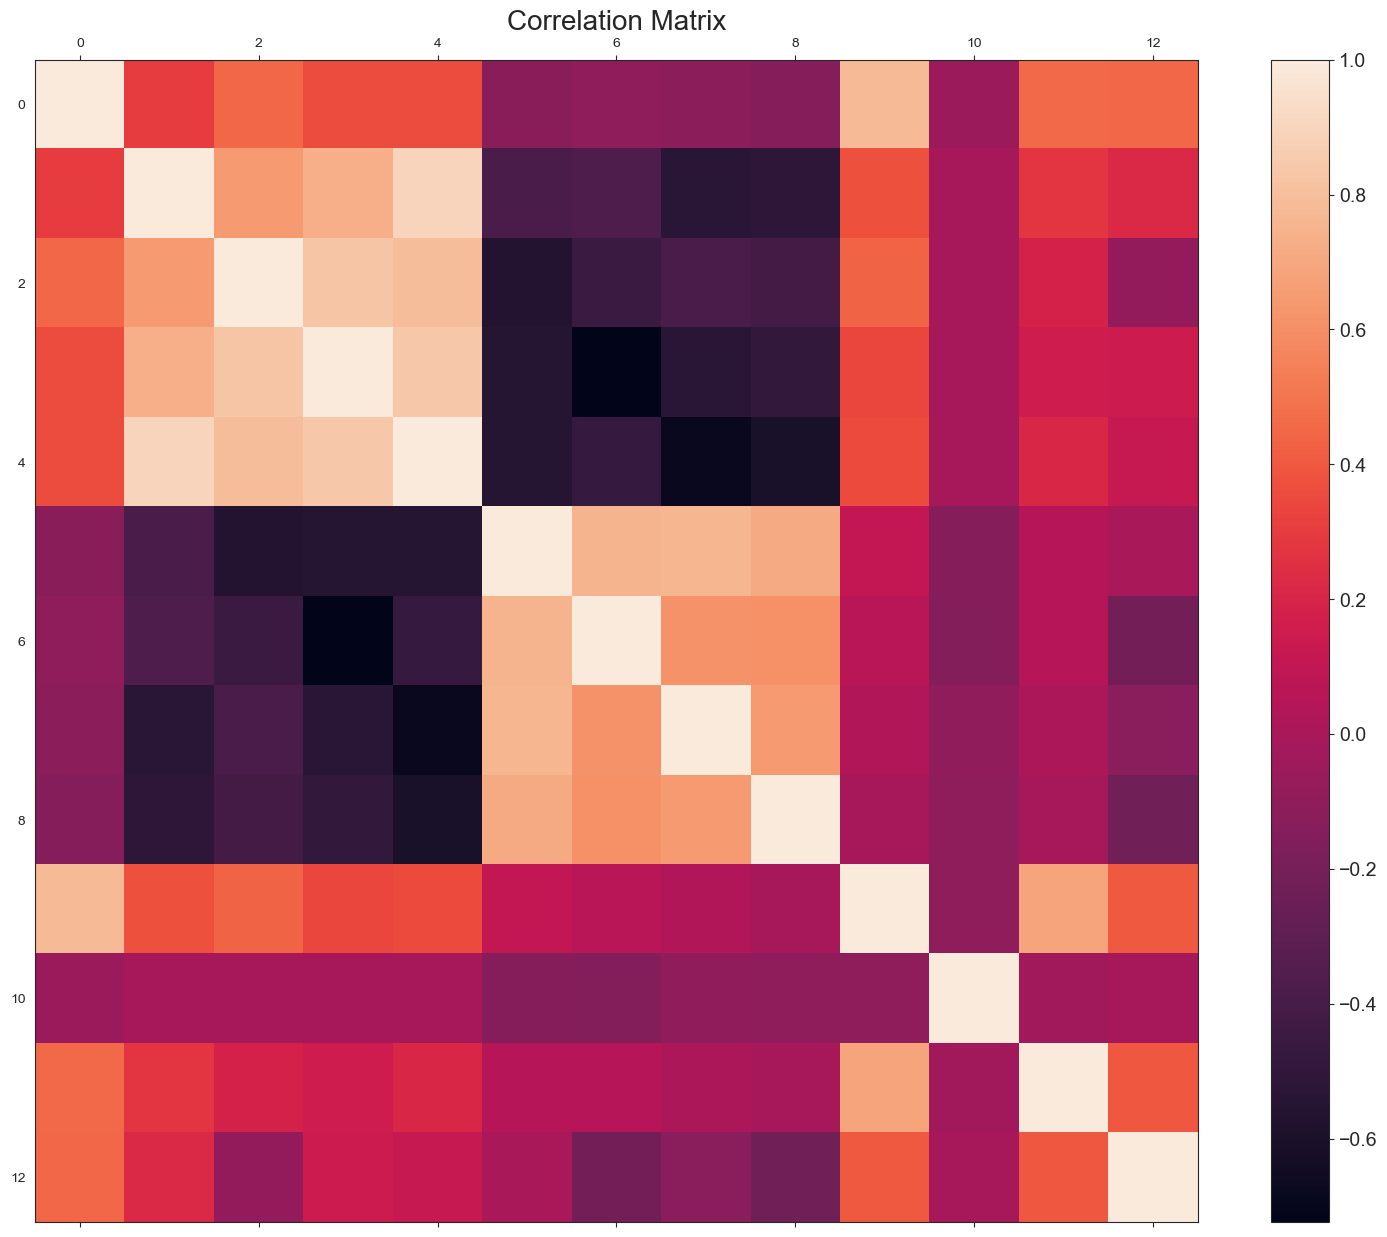

In [54]:
# Calculate correlation and plot figure
correlation = df_filtered.corr()                            # Calculate correlation
f = plt.figure(figsize=(19, 15))
plt.matshow(correlation, fignum=f.number)          

# choose axes range
#plt.xticks(range(df_filtered.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14, rotation=45)
#plt.yticks(range(df_filtered.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)

cb = plt.colorbar()  
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=20);

### Check missing values 


In [55]:
df_selected = df_filtered.copy()
missing_values = df_selected.isna().sum().sum()     
if missing_values > 0: 
   print('Remove missing values')
else: 
   print('No missing_values')

No missing_values


### Check duplicates

In [56]:
check_duplicate = df_selected.duplicated()
if check_duplicate.any():
    print("Duplicates exist in the DataFrame.")
else:
    print("All GOOD!")

All GOOD!


## Principal Component Analysis (PCA)

In [57]:
# Scaling the data 
df_copied = df_selected.copy()
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df_copied)

In [58]:
# Create principal components
pca = PCA()
df_pca = pca.fit_transform(df_scaled)

# Convert to dataframe
component_names = [f"PC{i+1}" for i in range(df_pca.shape[1])]
df_pca_converted = pd.DataFrame(df_pca, columns=component_names)

df_pca_converted.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13
0,-0.182969,0.205180,0.044228,-0.073059,-0.016945,0.006854,-0.026556,-0.053284,0.036243,0.010905,0.037862,-0.000719,0.009670
1,0.203542,-0.063382,-0.020295,-0.010955,-0.079926,-0.080195,-0.053317,0.030519,0.038716,0.007536,0.022479,0.005760,0.023020
2,-0.197646,0.160240,0.168480,-0.033756,0.047334,0.001393,-0.024683,-0.024837,0.080843,0.005001,0.021352,0.014949,0.020081
3,0.433985,-0.101052,-0.208655,0.051244,0.173036,-0.181615,0.084947,-0.125076,-0.033499,0.047602,0.050956,-0.025822,-0.018504
4,0.615202,0.187639,-0.080545,0.059984,-0.131544,-0.054737,-0.051192,-0.048199,-0.016831,-0.003714,-0.054187,0.031759,-0.019343


In [59]:
# Explained variance
evr = pca.explained_variance_ratio_
print(evr*100)
    
# Cumaltive Variance
cv = np.cumsum(evr)
print(cv)                                

# Need 7 principle components for 90%
# Need 2 principle compnents for 60% 

[47.04826065 21.74530461  8.62212871  6.33919317  4.19976195  3.72298906
  3.30322663  1.65972189  1.27565987  0.90506329  0.83182467  0.20662107
  0.14024443]
[0.47048261 0.68793565 0.77415694 0.83754887 0.87954649 0.91677638
 0.94980865 0.96640587 0.97916247 0.9882131  0.99653134 0.99859756
 1.        ]


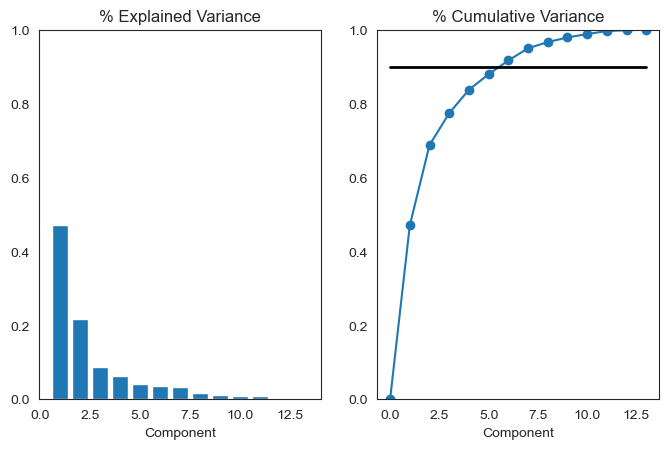

In [60]:
# Create figure
fig, axs = plt.subplots(1, 2)
n = pca.n_components_
grid = np.arange(1, n + 1)

# Explained variance
axs[0].bar(grid, evr)
axs[0].set(
    xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
)

# Cumulative Variance
axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
axs[1].plot([0, n], [0.9, 0.9], color='k', linestyle='-', linewidth=2)
axs[1].set(
    xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
)
        
# Set up figure
fig.set(figwidth=8, dpi=100);

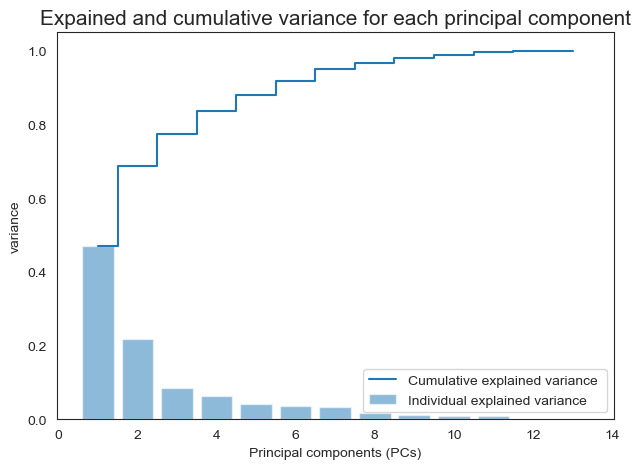

In [61]:
# Summery figure explained and cumulative variance
plt.bar(range(1,len(evr)+1), evr, alpha=0.5, align='center', label='Individual explained variance ')    # explained variance
plt.step(range(1,len(cv)+1), cv, where='mid',label='Cumulative explained variance ')       # Cumulative explained variance

plt.xlabel('Principal components (PCs)')
plt.ylabel('variance')
plt.title('Expained and cumulative variance for each principal component', fontsize=15)

plt.legend(loc='best')
plt.tight_layout()
plt.show()

### Loadings

In [62]:
loadings = pd.DataFrame(
   pca.components_.T,                     # transpose the pca matrix 
   columns=component_names,               # so the columns are the principal components
   index=df_selected.columns,                      # and the rows are the original features
)
loadings      

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13
ATS0Z,0.178514,0.281556,0.099987,0.290174,0.216390,-0.334473,0.150857,-0.401342,0.121694,0.073871,0.655513,0.000197,-0.046547
AATS4v,0.464672,-0.040589,-0.180647,-0.636336,0.107352,0.120544,0.120258,-0.045762,-0.093829,-0.471969,0.232271,-0.034823,-0.124676
AATS0p,0.383365,-0.046168,-0.386870,0.378013,-0.093363,-0.091344,0.003459,0.089410,0.507246,-0.187847,-0.251533,0.256573,-0.334046
AATS3p,0.386567,-0.124722,-0.098946,0.206096,0.204983,0.393529,-0.054864,0.202579,0.011081,0.368297,0.095227,-0.628298,-0.047122
AATS4p,0.402382,-0.102276,-0.170838,-0.218916,0.001288,-0.092212,0.016343,-0.189434,0.042710,0.519335,-0.137886,0.346660,0.543270
AATS0i,-0.178848,0.246357,-0.170161,-0.213717,0.247217,0.161388,0.087179,0.404025,-0.025670,0.427461,0.218673,0.416342,-0.412495
AATS3i,-0.235744,0.297737,-0.366561,-0.360707,-0.072608,-0.415282,0.094630,-0.061486,0.309134,0.177788,-0.176349,-0.489860,-0.051002
AATS4i,-0.136537,0.150009,-0.125244,0.064296,0.076156,0.086890,0.023594,0.509367,0.355210,-0.276542,0.297679,0.011867,0.611777
AATS5i,-0.257568,0.262135,-0.390397,0.110168,0.215263,0.578912,0.072362,-0.520374,0.016019,-0.107755,-0.125617,0.055650,0.110228
SM1_DzZ,0.290379,0.630624,-0.038620,0.199070,0.078367,-0.159678,0.104414,0.218741,-0.512389,-0.118221,-0.313697,-0.021955,0.105250


In [63]:
def plot_loadings(PC_1, PC_2):
    labels = loadings.index
    sns.set_style('white')
    sns.scatterplot(data=loadings, x=PC_1, y=PC_2, hue=labels, palette = 'Paired')

    plt.axhline(y=0, color='gray', linestyle='dotted')    
    plt.axvline(x=0, color='gray', linestyle='dotted')
    plt.axline((-0.2, -0.2), slope = 1,color ='r', linestyle = 'dotted')

    plt.legend(ncol =5, title = 'Variables', loc='center left', bbox_to_anchor=(1.0, 0.5))

Text(0.5, 1.0, 'Loadings principal components 1 and 2')

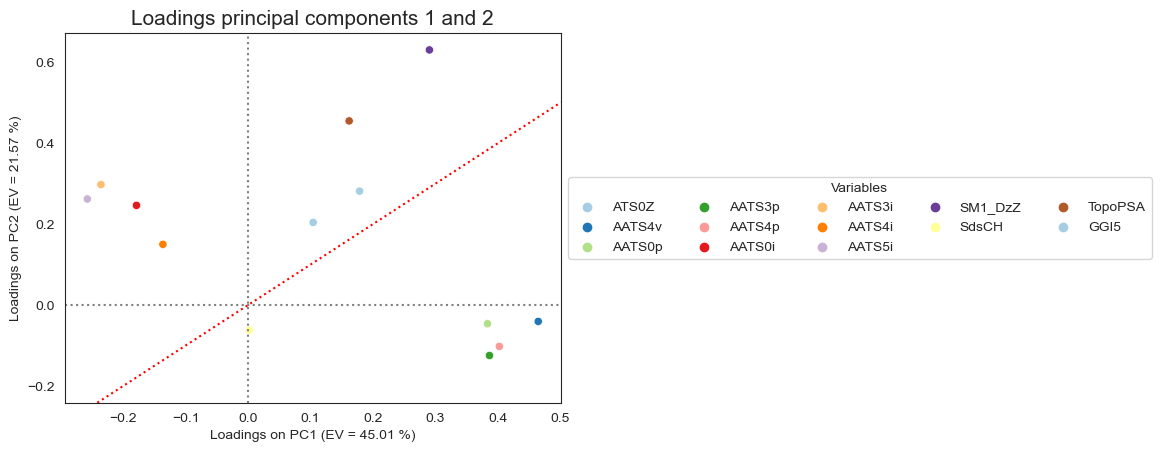

In [64]:
plot_loadings(PC_1 ='PC1', PC_2= 'PC2')               # IS ZO NIETS ZICHTBAAR< Worden te veel variabelen meegenomen. 

plt.xlabel('Loadings on PC1 (EV = 45.01 %)')
plt.ylabel('Loadings on PC2 (EV = 21.57 %)')
plt.title('Loadings principal components 1 and 2', fontsize = 15)

### Score plots 

In [65]:
def plot_scores(label,PC_1, PC_2):
    labels = original_df[label]
    sns.set_style('white')
    sns.scatterplot(x=df_pca[:, PC_1], y=df_pca[:, PC_2], hue=labels, palette= 'bright')

    plt.axhline(y=0, color='gray', linestyle='dotted')    
    plt.axvline(x=0, color='gray', linestyle='dotted')

    plt.legend(loc= 'best', ncol =2, title = label)

In [66]:
print(df_pca)

[[-0.18296949  0.20517977  0.04422751 ...  0.03786222 -0.00071857
   0.00967033]
 [ 0.20354151 -0.06338213 -0.0202952  ...  0.02247946  0.00576031
   0.02301956]
 [-0.19764634  0.16024017  0.16848015 ...  0.02135188  0.01494943
   0.02008132]
 ...
 [-0.23811116 -0.22455989 -0.08146297 ...  0.0130656   0.00841976
   0.00378535]
 [ 0.12268613  0.28923377  0.07682955 ...  0.02665519 -0.02837014
   0.01411369]
 [ 0.13415171  0.13319641 -0.12532508 ...  0.02131676 -0.00591613
   0.00393505]]


Text(0.5, 1.0, 'Scores separated by ALDH1 inhibition')

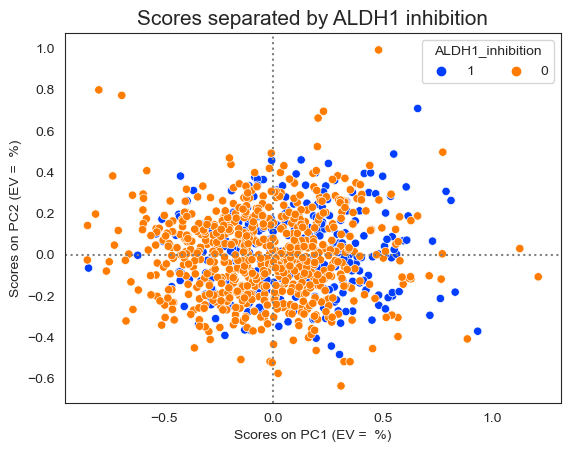

In [67]:
plot_scores(label= 'ALDH1_inhibition', PC_1= 0 , PC_2 = 1)

plt.xlabel('Scores on PC1 (EV =  %)')
plt.ylabel('Scores on PC2 (EV =  %)')
plt.title('Scores separated by ALDH1 inhibition', fontsize=15)

Text(0.5, 1.0, 'Scores separated by ALDH1 inhibition')

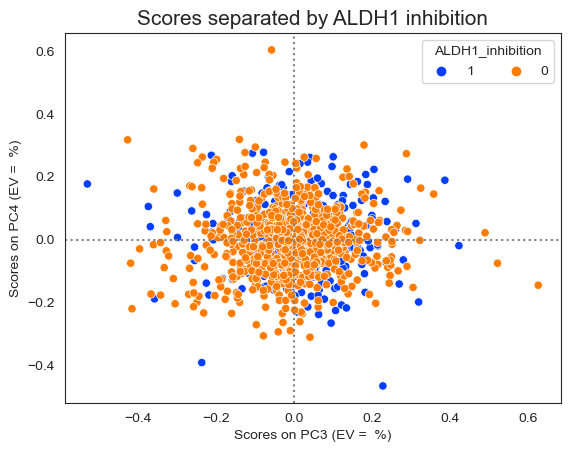

In [68]:
plot_scores(label= 'ALDH1_inhibition', PC_1= 2 , PC_2 = 3)

plt.xlabel('Scores on PC3 (EV =  %)')
plt.ylabel('Scores on PC4 (EV =  %)')
plt.title('Scores separated by ALDH1 inhibition', fontsize=15)

Text(0.5, 1.0, 'Scores separated by ALDH1 inhibition')

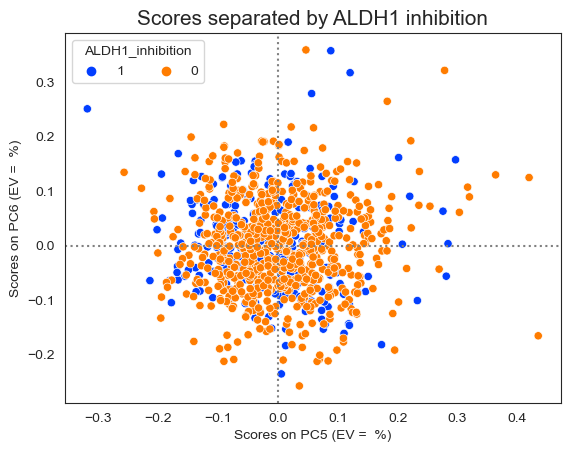

In [69]:
plot_scores(label= 'ALDH1_inhibition', PC_1= 4 , PC_2 = 5)

plt.xlabel('Scores on PC5 (EV =  %)')
plt.ylabel('Scores on PC6 (EV =  %)')
plt.title('Scores separated by ALDH1 inhibition', fontsize=15)

Text(0.5, 1.0, 'Scores separated by ALDH1 inhibition')

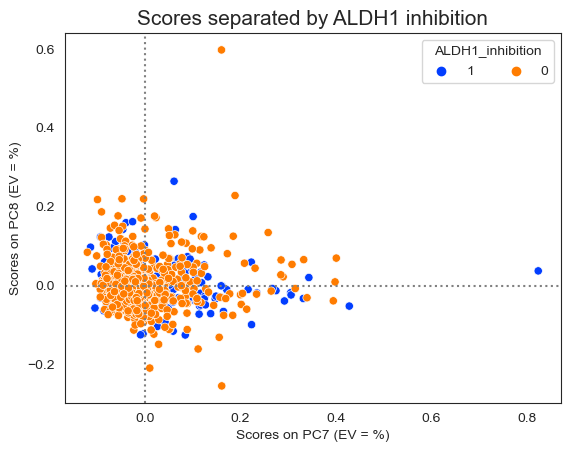

In [70]:
plot_scores(label= 'ALDH1_inhibition', PC_1= 6 , PC_2 = 7)

plt.xlabel('Scores on PC7 (EV = %)')
plt.ylabel('Scores on PC8 (EV = %)')
plt.title('Scores separated by ALDH1 inhibition', fontsize=15)

Text(0.5, 1.0, 'Scores separated by ALDH1 inhibition')

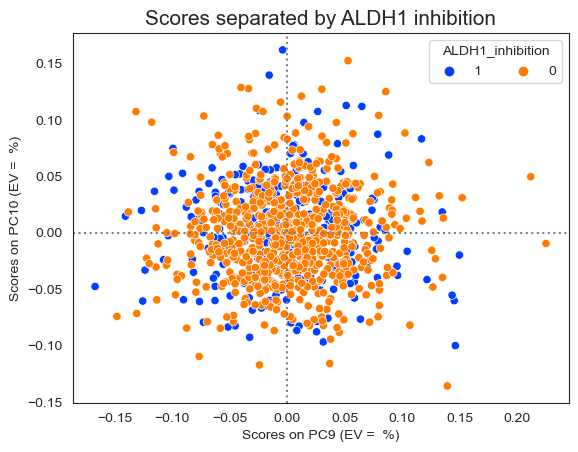

In [71]:
plot_scores(label= 'ALDH1_inhibition', PC_1= 8 , PC_2 = 9)

plt.xlabel('Scores on PC9 (EV =  %)')
plt.ylabel('Scores on PC10 (EV =  %)')
plt.title('Scores separated by ALDH1 inhibition', fontsize=15)

Text(0.5, 1.0, 'Scores separated by ALDH1 inhibition')

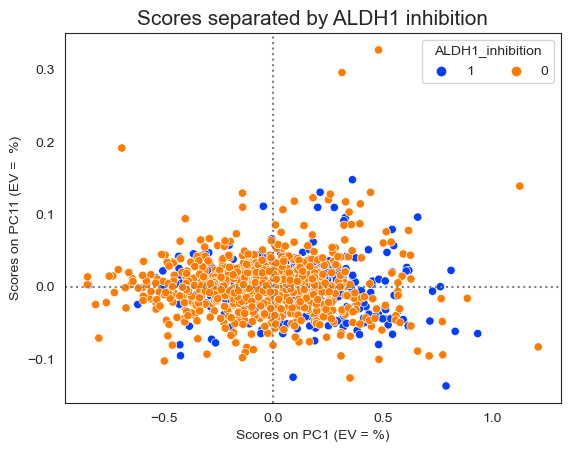

In [72]:
plot_scores(label= 'ALDH1_inhibition', PC_1= 0 , PC_2 = 10)

plt.xlabel('Scores on PC1 (EV = %)')
plt.ylabel('Scores on PC11 (EV =  %)')
plt.title('Scores separated by ALDH1 inhibition', fontsize=15)